In [9]:
import json
import random
import os
import re
import torch
from transformers.generation import (
    StoppingCriteria,
    StoppingCriteriaList,
    BeamSearchScorer,
    LogitsProcessorList,
    MaxLengthCriteria,
)
from transformers import LogitsProcessor
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Optional, Union, Tuple, List
from datasets import load_from_disk
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GenerationConfig
from transformers import HfArgumentParser
import os
import sys
from dataclasses import dataclass, field
from datasets import Dataset
import pandas as pd
import os
import json
import time
import matplotlib.pyplot as plt

In [10]:
domains = ["driverlog"]

for domain in domains:
    for mode in ["greedy"]:
        print(f"### Generazione con {domain} e {mode}")
        path = f"config.json"
        params = {
            "domain": domain,
            "model_dir": f"./models/{domain}/", 
            "dataset_dir": f"./{domain}-dataset-tesi/",
            "num_beams": 1,
            "num_return_beams": 1,
            "split_dataset": "test",
            "output_dir": f"{domain}-generations-tesi/greedy/",
        }
        with open(path, "w") as file:
            tmp = json.dumps(params, indent=4)
            file.write(tmp)
        with open(path, "r") as file:
            # Carica il contenuto del file JSON in una variabile
            data = json.load(file)
        print("### Generazione con " + path)
        print(json.dumps(data, indent=4))

### Generazione con driverlog e greedy
### Generazione con config.json
{
    "domain": "driverlog",
    "model_dir": "./models/driverlog/",
    "dataset_dir": "./driverlog-dataset-tesi/",
    "num_beams": 1,
    "num_return_beams": 1,
    "split_dataset": "test",
    "output_dir": "driverlog-generations-tesi/greedy/"
}


In [11]:
@dataclass
class PlanGeneratorArguments:
    domain: str = field(
        default="driverlog",
        metadata={"help": "The domain of the problems"},
    )
    model_dir: str = field(
        default="output_new_finetuning_more_batch/checkpoint-258502/",
        metadata={"help": "The model directory"},
    )
    dataset_dir: str = field(
        default="data/ipc/driverlog/random_new_correct_with_invariants_and_types/",
        metadata={"help": "The dataset directory"},
    )
    add_start: bool = field(
        default=False,
        metadata={"help": "Add the start token to the prompt"},
    )
    split_dataset: str = field(
        default="validation",
        metadata={"help": "The split of the dataset to use"},
    )
    output_dir: str = field(
        default="output_coverage_beam_search/",
        metadata={"help": "The output directory"},
    )
    # generation parameters
    num_beams: int = field(
        default=1,
        metadata={"help": "The number of beams to track"},
    )
    num_return_beams: int = field(
        default=1,
        metadata={"help": "The number of beams to return"},
    )
    max_length: int = field(
        default=2048,
        metadata={"help": "The maximum length of the generated plan"},
    )   
    do_sample: bool = field(
        default=False,
        metadata={"help": "If to sample the generation"},
    )
    top_p: float = field(
        default=1.0,
        metadata={"help": "The top_p parameter for the generation"},
    )

In [12]:
# Create an instance of HfArgumentParser with your argument class
parser = HfArgumentParser(PlanGeneratorArguments)

(args,) = parser.parse_json_file(json_file=path)

dataset_dir = args.dataset_dir
model_path = args.model_dir
domain = args.domain

print(dataset_dir, model_path, domain)

# check if exists
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir, exist_ok=True)

./driverlog-dataset-tesi/ ./models/driverlog/ driverlog


In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
if "ape" in model_path:
    model = GPT2_ape.from_pretrained(model_path)
else:    
    model = AutoModelForCausalLM.from_pretrained(model_path)
model.to("cuda")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(570, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=570, bias=False)
)

In [14]:
generation_config = GenerationConfig(
        num_beams=args.num_beams,
        max_length=args.max_length,
        do_sample=args.do_sample,
        num_return_sequences=args.num_return_beams,
        top_p=args.top_p,
)
print("Generation config loaded")
# print("Generation mode: ", generation_config.get_generation_mode()) # works only with transformers 4.40 +

print("Model and Tokenizer loaded")

Generation config loaded
Model and Tokenizer loaded


### dict

In [15]:
dict_actions_dr = {}
dict_predicates_dr = {}
dict_objects_dr = {}
dict_actions_dr["load-truck"] = (
    ["obj", "truck", "location"],
    ["at 0 2", "at 1 2"],
    ["in 0 1"],
    ["at 0 2"],
)
dict_actions_dr["unload-truck"] = (
    ["obj", "truck", "location"],
    ["at 1 2", "in 0 1"],
    ["at 0 2"],
    ["in 0 1"],
)
dict_actions_dr["board-truck"] = (
    ["driver", "truck", "location"],
    ["at 1 2", "at 0 2", "empty 1"],
    ["driving 0 1"],
    ["at 0 2", "empty 1"],
)
dict_actions_dr["disembark-truck"] = (
    ["driver", "truck", "location"],
    ["at 1 2", "driving 0 1"],
    ["at 0 2", "empty 1"],
    ["driving 0 1"],
)
dict_actions_dr["drive-truck"] = (
    ["truck", "location", "location", "driver"],
    ["at 0 1", "driving 3 0", "link 1 2"],
    ["at 0 2"],
    ["at 0 1"],
)
dict_actions_dr["walk"] = (
    ["driver", "location", "location"],
    ["at 0 1", "path 1 2"],
    ["at 0 2"],
    ["at 0 1"],
)

dict_predicates_dr["at"] = (["obj", "airplane", "truck"], ["location"])
dict_predicates_dr["in"] = (["obj"], ["truck"])
dict_predicates_dr["driving"] = (["driver"], ["truck"])
dict_predicates_dr["link"] = (["location"], ["location"])
dict_predicates_dr["path"] = (["location"], ["location"])
dict_predicates_dr["empty"] = (["truck"],)

dict_predicates_dr["location"] = ["ob"]
dict_predicates_dr["obj"] = ["ob"]
dict_predicates_dr["driver"] = ["ob"]
dict_predicates_dr["truck"] = ["ob"]

dict_objects_dr["location"] = ["s", "p-", "p"]
dict_objects_dr["locatable"] = ["driver", "truck", "package"]
dict_objects_dr["driver"] = ["driver"]
dict_objects_dr["truck"] = ["truck"]
dict_objects_dr["obj"] = ["package"]

convert_action_dr = {}
convert_action_dr["p01"] = "p1"
convert_action_dr["p02"] = "p2"
convert_action_dr["p03"] = "p3"
convert_action_dr["p04"] = "p4"
convert_action_dr["p05"] = "p5"
convert_action_dr["p06"] = "p6"
convert_action_dr["p07"] = "p7"
convert_action_dr["p08"] = "p8"
convert_action_dr["p09"] = "p9"
convert_action_dr1 = {}

dict_actions_domain = {}
dict_predicates_domain = {}
dict_objects_domain = {}
convert_action_domain = {}
convert_action_domain1 = {}

dict_actions_domain["driverlog"] = dict_actions_dr
dict_predicates_domain["driverlog"] = dict_predicates_dr
dict_objects_domain["driverlog"] = dict_objects_dr
convert_action_domain["driverlog"] = convert_action_dr

In [16]:
def estrai_p(input):
    parole_con_p = re.findall(r'p\d+', input)
    return parole_con_p

In [17]:
def unite_actions(input, keywords, domain, separator="_"):
    for conversion in convert_action_domain1[domain].keys():         
        input = input.replace(conversion, convert_action_domain1[domain][conversion])
    for conversion in convert_action_domain[domain].keys():         
        input = input.replace(conversion, convert_action_domain[domain][conversion])
    list_to_unite = input.split()    
    index_actions = []
    for idx, token in enumerate(list_to_unite):
        if token in keywords:            
            index_actions.append(idx)    
    index_actions.append(len(list_to_unite))
    new_list = []
    for i in range(len(index_actions) - 1):        
        new_action = " ".join(list_to_unite[index_actions[i] : index_actions[i + 1]])        
        new_list.append(new_action.replace(" ", separator))
    return new_list

### gestione file template

In [18]:
def initial_state(path):
    with open(path, "r") as f:
        righe = f.readlines()
        inizio = False
        state = ""

        for riga in righe:  
            if "_100" in path:
                if " - " in riga:
                    riga = riga.replace("-", " ").split()
                    riga = riga[::-1]
                    riga = " ".join(riga)
                    state += riga + " "   
                                           
            riga = riga.strip().replace("(", "").replace(")", "").replace("-", "").lower()
            if riga == "":
                inizio = False
            if inizio:
                state += riga + " "
            if riga == ":init":
                inizio = True

    return state

In [19]:
def get_goals(path):
    goals = []
    with open(path, "r") as f:
        righe = f.readlines()
        for riga in righe:
            riga = riga.strip().replace("(", "").replace(")", "").replace(",", "").lower()
            goals.append(riga)
    return goals

In [20]:
import re

def get_actions(path):
    actions = []
    with open(path, "r") as f:
        righe = f.readlines()
        for riga in righe:
            riga = riga.strip().replace("(", "").replace(")", "").lower()
            riga = re.sub(r"(?<=\d)-(?=\d)", "", riga)
            actions.append(riga)
    return actions

In [21]:
def create_starting_structures(plan, domain):

    initial_states = (
        plan["input"].split("<|goals|>")[0].strip().split("<|startofplan|>")[1].strip()
    )  
       
    goal_states = (
        plan["input"].split("<|goals|>")[1].strip().split("<|actions|>")[0].strip()
    )
    
    initial_states = unite_actions(
        initial_states, list(dict_predicates_domain[domain].keys()), domain
    )
    goal_states = unite_actions(
        goal_states, list(dict_predicates_domain[domain].keys()), domain
    )
    if "<|endofplan|>" in plan["actions"]:
        actions = unite_actions(
            plan["actions"].split("<|endofplan|>").strip(),
            list(dict_actions_domain[domain].keys()),
            domain,
        )
    else:
        actions = unite_actions(
            plan["actions"], list(dict_actions_domain[domain].keys()), domain
        )
        
    
    dict_states = {}
    dict_goals = {}
    for init_state in initial_states:
        dict_states[init_state] = True
    for goal_state in goal_states:
        if goal_state in initial_states:
            dict_goals[goal_state] = True
        else:
            dict_goals[goal_state] = False    
    return (dict_states, dict_goals, actions)

In [22]:
def rimuovi_numeri(stringa):
    return "".join([i for i in stringa if not i.isdigit()])

In [23]:
def check_goals(states, goal_states, domain):
    all_goals_satisfied = True
    goals_unsatisfied_list = []
    goals_unsatisfied_list_nonumber = []
    # print(goal_states)
    for goal in goal_states.keys():
        # print("Analizzo il goal " + goal)
        if goal not in states.keys():
            goal_states[goal] = False
            all_goals_satisfied = False
            goals_unsatisfied_list.append(goal)
            goals_unsatisfied_list_nonumber.append(rimuovi_numeri(goal))
            # print("Il mio goal non è negli stati visti")
        elif states[goal] is False:
            goal_states[goal] = False
            all_goals_satisfied = False
            goals_unsatisfied_list.append(goal)
            goals_unsatisfied_list_nonumber.append(rimuovi_numeri(goal))
            # print("Il mio goal è negli stati visti falso")
        else:
            goal_states[goal] = True
            # print("Il mio goal è negli stati visti vero")
    if all_goals_satisfied is True:
        return (True, goal_states, "goals_succesfull")
    else:
        return (
            False,
            goal_states,
            "goals_not_succesfull",
            goals_unsatisfied_list_nonumber,
            goals_unsatisfied_list,
        )

In [24]:
def execute_action(states, action, domain):
    # Return a Tuple
    # in the first position the result True, False
    # in the second position the next state if result is True or the current state if it is False
    # in the third position the motivation of the wrong execution
    # split my action, on position 0 the action, then the objects
    # print(action)
    splitted_action = action.split("_")[0]  # prendo il nome della mia azione
    try:
        action_parameter = dict_actions_domain[domain][
            splitted_action
        ]  # verifico che l'azione esiste
    except:
        action_parameter = None
    if action_parameter is None:
        return (False, states, "action_name_wrong", splitted_action, action, "")
    splitted_objects = action.split("_")[
        1:
    ]  # ottengo il nome dei miei oggetti definiti nel mio problema
    action_objects = action_parameter[0]  # ottengo gli oggetti accettati dall'azione
    if len(action_objects) == len(
        splitted_objects
    ):  # verifico che gli oggetti siano in egual numero rispetto a quanti ne richiede la mia azione
        for i in range(0, len(action_objects)):  # scorro i miei oggetti
            obj_nonumber = "".join(
                [j for j in splitted_objects[i] if not j.isdigit()]
            )  # calcolo il mio nome dell'oggetto senza tener conto dei numeri
            if (
                obj_nonumber not in dict_objects_domain[domain][action_objects[i]]
            ):  # verifico che l'oggetto si trovi nella lista di nomi possibili associata alla descrizione dell'azione
                print("Errore: " + obj_nonumber + " non è un oggetto valido per " + action_objects[i])
                print("Gli oggetti validi sono: " + str(dict_objects_domain[domain][action_objects[i]]))
                return (
                    False,
                    states,
                    "object_name_wrong",
                    splitted_action,
                    obj_nonumber,
                    splitted_objects[i],
                )
    else:
        return (
            False,
            states,
            "object_number_wrong",
            splitted_action,
            len(action_objects),
            len(splitted_objects),
        )

    action_prec = action_parameter[1]  # prendo le precondizioni della mia azione
    violed_precondtion = False
    violed_preconditions_list = []
    violed_preconditions_list_nonumber = []
    for prec in action_prec:  # scorro le mie precondizioni
        prec_list = prec.split(" ")
        prec_parametrized = "" + prec_list[0]  # metto il mio predicato
        for obj in prec_list[1:]:  # scorro gli oggetti della mia precondizione
            prec_parametrized = (
                prec_parametrized + "_" + splitted_objects[int(obj)]
            )  # sostituisco gli oggetti generici ai miei oggetti del problema
        if (
            prec_parametrized not in states.keys()
        ):  # controllo se la mia precondizione esiste come chiave del dizionario (se non esiste non è vera)
            violed_precondtion = True
            violed_preconditions_list.append(prec_parametrized)
            violed_preconditions_list_nonumber.append(rimuovi_numeri(prec_parametrized))
        elif (
            states[prec_parametrized] is False
        ):  # controllo che la mia precondizione sia vera per eseguire l'azione
            violed_precondtion = True
            violed_preconditions_list.append(prec_parametrized)
            violed_preconditions_list_nonumber.append(rimuovi_numeri(prec_parametrized))
        else:
            pass
    if violed_precondtion is True:
        return (
            False,
            states,
            "violed_preconditions",
            violed_preconditions_list_nonumber,
            violed_preconditions_list,
            splitted_action,
        )

    # eseguo gli effetti negativi
    action_neg = action_parameter[3]  # prendo i miei effetti negativi
    for neg in action_neg:  # li scorro
        neg_list = neg.split(" ")
        neg_parametrized = "" + neg_list[0]  # ottengo il mio predicato
        for obj in neg_list[1:]:  # per ogni oggetto (rappresentato come indice)
            neg_parametrized = (
                neg_parametrized + "_" + splitted_objects[int(obj)]
            )  # vado a sostituirlo col corrispettivo dell'azione in corso
        states[neg_parametrized] = False  # cambio il valore nei miei stati
        # print("ho reso falso " + neg_parametrized)

    # eseguo gli effetti additivi
    action_plus = action_parameter[2]  # prendo i miei effetti additivi
    for plus in action_plus:  # li scorro
        plus_list = plus.split(" ")
        plus_parametrized = "" + plus_list[0]  # ottengo il mio predicato
        for obj in plus_list[1:]:  # per ogni oggetto (rappresentato come indice)
            plus_parametrized = (
                plus_parametrized + "_" + splitted_objects[int(obj)]
            )  # vado a sostituirlo col corrispettivo dell'azione in corso
        states[plus_parametrized] = True  # cambio il valore nei miei stati
        # print("ho reso vero " + plus_parametrized)

    return (True, states, "action_succesfull")

In [25]:
def check_violated_preconditions(plan, domain):
    init_structures = create_starting_structures(plan, domain)
    init_state = init_structures[0]
    goal_state = init_structures[1]
    actions = init_structures[2]
    if len(actions) == 0 and len(plan["actions"]) != 0:
        return True  # Il modello ha generato i token iniziali diversi da azioni (parole a caso)
    # print("Actions ", actions)
    result_goals = check_goals(init_state, goal_state, domain)
    state = init_state
    for action in actions:
        result = execute_action(state, action, domain)
        # print("Res action ", result)
        if result[0] is True:
            state = result[1]
        else:
            error_type = result[2]
            if error_type == "object_name_wrong":
                return True
            elif error_type == "object_number_wrong":
                if result[4] > result[5]:
                    return False
                else:
                    return True
            elif error_type == "violed_preconditions":
                return True
            elif error_type == "action_name_wrong":
                return True
    return False

In [26]:
def calculate_reward(plan, domain):    
  
    init_structures = create_starting_structures(plan, domain)
    init_state = init_structures[0]
    goal_state = init_structures[1]
    actions = init_structures[2]

    start = time.time()

    result_goals = check_goals(init_state, goal_state, domain)
    if result_goals[0] is True:
        return 1
    else:
        pass
    state = init_state
    j = 0
    for action in actions:
        start_act = time.time()
        result = execute_action(state, action, domain)
        if result[0] is True:
            # print(result[2])
            state = result[1]
            result_goals = check_goals(state, goal_state, domain)
            if result_goals[0] is True:
                return 1
            else:
                pass
                # print(result_goals[2])
        else:
            result_goals = check_goals(state, goal_state, domain)
            goals_satisfied = result_goals[1]
            count = 0
            n_goals = len(goals_satisfied.keys())
            for goal in goals_satisfied.keys():
                if goals_satisfied[goal] is True:
                    count += 1
            if check_violated_preconditions(plan, domain) is True:
                return (count / n_goals) - 1
            else:
                return count / n_goals
        j = j + 1
        end_act = time.time()
        # print("Ho impiegato per fare una azione: " + str(end_act-start_act))

    number_missing_actions = len(actions) - j
    end = time.time()
    # print("Ho impiegato " + str(end-start))
    goals_satisfied = result_goals[1]
    count = 0
    n_goals = len(goals_satisfied.keys())
    for goal in goals_satisfied.keys():
        if goals_satisfied[goal] is True:
            count += 1
    return count / n_goals

In [27]:
def parse_problem(plan, domain):    
   
            
    init_structures = create_starting_structures(plan, domain) # riporta i dizionari dei fluenti iniziali e dei fluenti obiettivo e l'inisieme delle azioni generate
    init_state = init_structures[0]  # dizionario con tutti i fluenti iniziali con assocciato il valore true
    goal_state = init_structures[1]  # dizionario con i fluenti obiettivo con associato il valore true o false in base ai fluenti iniziali
    actions = init_structures[2]     # vettore contenente le azioni generate da planGPT
    
    start = time.time()

    result_goals = check_goals(init_state, goal_state, domain)   
        
    if result_goals[0] is True:
        return (result_goals[0], result_goals[1], result_goals[2], len(actions))
        # print(result_goals[2])
    else:
        pass
        # print(result_goals[2])

    state = init_state    
    j = 0
    for action in actions:
        start_act = time.time()
        result = execute_action(state, action, domain)
        if result[0] is True:
            # print(result[2])
            state = result[1]
            result_goals = check_goals(state, goal_state, domain)
            if result_goals[0] is True:
                # print(result_goals[2])
                j = j + 1
                break
            else:
                pass
                # print(result_goals[2])
        else:
            result_goals = check_goals(state, goal_state, domain)
            return (
                result[0],
                result_goals[1],
                result[2],
                result[3],
                result[4],
                result[5],
                j,
            )
            # print(result[2])
            # print(result[1])
            break
        j = j + 1
        end_act = time.time()
        # print("Ho impiegato per fare una azione: " + str(end_act-start_act))

    number_missing_actions = len(actions) - j
    end = time.time()
    # print("Ho impiegato " + str(end-start))
    return (result_goals[0], result_goals[1], result_goals[2], number_missing_actions)

### run

In [ ]:
counter = 0
last_generated = 0
generation_output = []
total_plans = 0
tot_time = 0
tot_skip = 0
v=0
vettore_tokenizer = [f"p{i}" for i in range(0, 381)]

for folder in os.listdir(dataset_dir):   
    convert_action_dr1 = {}
    v+=1
    print(v, folder)  
    cont=0
    cont_action=0
    for file in os.listdir(os.path.join(dataset_dir, folder)):
        path = os.path.join(dataset_dir, folder, file)
        if file == "template.pddl":
            state = initial_state(path)                       
        elif file == "hyps.dat":
            goals = get_goals(path) 
        elif file == "obs.dat":
            actions = get_actions(path)           
        elif file == "real_hyp.dat":
            real_goal = get_goals(path)
            
    for conversion in convert_action_domain[domain].keys():         
        state = state.replace(conversion, convert_action_domain[domain][conversion])
        
    vettore_p = estrai_p(state)
    elementi_disponibili = [elemento for elemento in vettore_tokenizer if elemento not in vettore_p]
    for elemento in vettore_p:
        if elemento not in vettore_tokenizer:
            elemento_casuale = random.choice(elementi_disponibili)
            convert_action_dr1[elemento] = elemento_casuale
            elementi_disponibili.remove(elemento_casuale)
            
    #print(convert_action_dr1)
    convert_action_domain1["driverlog"] = convert_action_dr1   
    
    state = unite_actions(
        state,
        list(dict_predicates_domain[domain].keys()),
        domain,
    )
    state = [x.replace("_", " ") for x in state]
    state = sorted(state)
    state = " ".join(state)    
    
    for r_goal in real_goal:
        r_goal = unite_actions(
            r_goal,
            list(dict_predicates_domain[domain].keys()),
            domain,
        )
        r_goal = [x.replace("_", " ") for x in r_goal]
        r_goal = sorted(r_goal)
        r_goal = " ".join(r_goal)
    
    prompts = []
    prompts_tokenized = []
    goals_sorted = []
    for goal in goals:
        goal = unite_actions(
            goal,
            list(dict_predicates_domain[domain].keys()),
            domain,
        )

        goal = [x.replace("_", " ") for x in goal]
        goal = sorted(goal)
        goal = " ".join(goal)
        goals_sorted.append(goal)
        prompt = state + " <|goals|> " + goal + " <|actions|>"
        prompts.append(prompt)
        prompt_tokenized = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=args.max_length)
        prompt_tokenized = prompt_tokenized["input_ids"].to(model.device)
        prompts_tokenized.append(prompt_tokenized)
        for action in actions:  
            for conversion in convert_action_domain1[domain].keys():         
                action = action.replace(conversion, convert_action_domain1[domain][conversion])
            for conversion in convert_action_domain[domain].keys():         
                action = action.replace(conversion, convert_action_domain[domain][conversion])         
            prompt = prompt + action + " "    
            prompts.append(prompt)
            prompt_tokenized = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=args.max_length)
            prompt_tokenized = prompt_tokenized["input_ids"].to(model.device)
            prompts_tokenized.append(prompt_tokenized)    
            
    skip_number=0
    for prompt_tokenized in prompts_tokenized:   
        if skip_number>0:            
            skip_number-=1 
        else:            
            with torch.inference_mode():                
                start_time = time.time()
                generated = model.generate(
                    prompt_tokenized,
                    pad_token_id=tokenizer.eos_token_id,
                    max_length=args.max_length,
                    generation_config=generation_config,
                )
                end_time = time.time()
                delta_time = end_time - start_time
                tot_time+=delta_time
                
            found_true = False
            plans = []
            for index, output_tokenized in enumerate(generated):
                output = tokenizer.decode(output_tokenized)                 
                inputs = output.split("<|actions|>")[0]
                plan = output.split("<|actions|>")[1]
                if "<|endofplan|>" in plan:        
                    plan = plan.split("<|endofplan|>")[0]
                plan = plan.replace("<|endofplan|>", "")
                plan = plan.replace("<|startofplan|>", "")
                plan = plan.replace("<|pad|>", "")
                p = {"input": inputs, "actions": plan}       
                res = parse_problem(p, domain=domain)   
                metric_goals_satisfated=calculate_reward(p,domain=domain)   
                plans.append({"plan": plan, "result": res})  
                if res[0] is True:
                    found_true = True
                
            if found_true is True:
                counter += 1            
            
            actions_string = " ".join(actions) 
            
            ## controllo se il piano generato  è uguale alle azioni da aggiungere            
            
            # if plans[0]["plan"].strip() == actions_string:  
            #     # print(plans[0]["result"][0])  
            #     # print(goals[cont])        
            #     skip_number = len(actions)-cont_action
            #     tot_skip+=skip_number
            #     if skip_number>0:
            #         total_plans+=(cont_action+1)
            #     if plans[0]["result"][0]:
            #         counter+=skip_number 
            
            if r_goal == goals_sorted[cont]:  
                true_goal = True                        
            else:
                true_goal = False               
          
                
            generation_output.append(
                {
                    "name": folder,
                    "goal": goals[cont],
                    "input": prompts[cont_action], #cont or cont_action
                    "action": prompts[cont_action].split("<|actions|>")[1],
                    "true_goal": true_goal,
                    "actions": actions_string,
                    "plans": plans,
                    "value of the metric goals satisfated": metric_goals_satisfated,
                    #"actions": actions,
                    "time": format(delta_time, ".2f"),
                }
            )  
            cont_action+=1
            if cont_action > len(actions):            
                total_plans+=cont_action            
                cont_action=0
                cont+=1 
            
            
            if skip_number>0:
                cont_action=0
                cont+=1            
    
    
    # Save the last batch
    with open(
        os.path.join(args.output_dir, f"generation_output_100p_actions_NewTest.json"),
        "w",
    ) as f:
        json.dump(generation_output, f, indent=4) 
        
    with open(os.path.join(args.output_dir, f"generation_results_100p_actions_NewTest.txt"), "w") as f:
        f.write(f"Correct plans: {counter}\n")
        f.write(f"Skip plan generation: {tot_skip}\n")
        f.write(f"Total plans: {total_plans}\n")
        percent = counter / total_plans * 100.0
        f.write(f"Coverage: {percent}%\n")  
        f.write(f"Total time: {tot_time}\n")
        
    break
            
        

1 driverlog_p03_hyp-2_full


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


72 driverlog_p003853_hyp=hyp-3_100
Errore: driver non è un oggetto valido per location
Gli oggetti validi sono: ['s', 'p-', 'p']
Errore: driver non è un oggetto valido per location
Gli oggetti validi sono: ['s', 'p-', 'p']
Errore: driver non è un oggetto valido per location
Gli oggetti validi sono: ['s', 'p-', 'p']

### run 2

In [ ]:
counter = 0
last_generated = 0
generation_output = []
total_plans = 0
tot_time = 0
v=0
vettore_tokenizer = [f"p{i}" for i in range(0, 381)]


for folder in os.listdir(dataset_dir):  
    convert_action_dr1 = {}
    v+=1
    print(v,folder)        
    cont=0    
    for file in os.listdir(os.path.join(dataset_dir, folder)):
        path = os.path.join(dataset_dir, folder, file)
        if file == "template.pddl":
            state = initial_state(path)                
        elif file == "hyps.dat":
            goals = get_goals(path) 
        elif file == "obs.dat":
            actions = get_actions(path)  
        elif file == "real_hyp.dat":
            real_goal = get_goals(path)     
                     
    for conversion in convert_action_domain[domain].keys():         
        state = state.replace(conversion, convert_action_domain[domain][conversion])
        
    vettore_p = estrai_p(state)
    elementi_disponibili = [elemento for elemento in vettore_tokenizer if elemento not in vettore_p]
    for elemento in vettore_p:
        if elemento not in vettore_tokenizer:
            elemento_casuale = random.choice(elementi_disponibili)
            convert_action_dr1[elemento] = elemento_casuale
            elementi_disponibili.remove(elemento_casuale)
            
    #print(convert_action_dr1)
    convert_action_domain1["driverlog"] = convert_action_dr1   
    
   
    state = unite_actions(
        state,
        list(dict_predicates_domain[domain].keys()),
        domain,
    )
    state = [x.replace("_", " ") for x in state]
    state = sorted(state)
    state = " ".join(state)     
    
    
    for r_goal in real_goal:
        r_goal = unite_actions(
            r_goal,
            list(dict_predicates_domain[domain].keys()),
            domain,
        )
        r_goal = [x.replace("_", " ") for x in r_goal]
        r_goal = sorted(r_goal)
        r_goal = " ".join(r_goal)   
        
    prompts = []
    prompts_tokenized = []
    goals_sorted = []
    for goal in goals:
        goal = unite_actions(
            goal,
            list(dict_predicates_domain[domain].keys()),
            domain,
        )

        goal = [x.replace("_", " ") for x in goal]
        goal = sorted(goal)
        goal = " ".join(goal)        
        goals_sorted.append(goal)
        prompt = state + " <|goals|> " + goal + " <|actions|>"
        prompts.append(prompt)
        prompt_tokenized = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=args.max_length)
        prompt_tokenized = prompt_tokenized["input_ids"].to(model.device)
        prompts_tokenized.append(prompt_tokenized) 
    
    for prompt_tokenized in prompts_tokenized:        
        
        with torch.inference_mode():
            start_time = time.time()
            generated = model.generate(
                prompt_tokenized,
                pad_token_id=tokenizer.eos_token_id,
                max_length=args.max_length,
                generation_config=generation_config,
            )
            end_time = time.time()
            delta_time = end_time - start_time
            tot_time+=delta_time
            
        found_true = False
        plans = []
        for index, output_tokenized in enumerate(generated):            
            output = tokenizer.decode(output_tokenized)                          
            inputs = output.split("<|actions|>")[0]
            plan = output.split("<|actions|>")[1]
            if "<|endofplan|>" in plan:        
                plan = plan.split("<|endofplan|>")[0]
            plan = plan.replace("<|endofplan|>", "")
            plan = plan.replace("<|startofplan|>", "")
            plan = plan.replace("<|pad|>", "")
            p = {"input": inputs, "actions": plan}       
            res = parse_problem(p, domain=domain) 
            metric_goals_satisfated=calculate_reward(p,domain=domain) 
            plans.append({"plan": plan, "result": res})  
            if res[0] is True:
                found_true = True
            
        if found_true is True:
            counter += 1            
        
        actions_string = " ".join(actions)   
        
       
        if r_goal == goals_sorted[cont]:            
            true_goal = True  
        else:
            true_goal = False 
            
                       
        generation_output.append(
            {
                "name": folder,
                "goal": goals[cont],
                "input": prompts[cont],               
                "true_goal": true_goal,
                "actions": actions_string,
                "plans": plans, 
                "value of the metric goals satisfated": metric_goals_satisfated,
                "time": format(delta_time, ".2f"),
            }
        ) 
          
        cont+=1         
        
    total_plans+=cont 
    
    # Save the last batch
    with open(
        os.path.join(args.output_dir, f"generation_output_100p_NewTest1.json"),
        "w",
    ) as f:
        json.dump(generation_output, f, indent=4) 
        
    with open(os.path.join(args.output_dir, f"generation_results_100p_NewTest1.txt"), "w") as f:
        f.write(f"Correct plans: {counter}\n")        
        f.write(f"Total plans: {total_plans}\n")
        percent = counter / total_plans * 100.0
        f.write(f"Coverage: {percent}%\n")  
        f.write(f"Total time: {tot_time}\n")  
        
     
    

1 driverlog_p03_hyp-2_full
{}
2 driverlog_p07_hyp-2_full
{}
3 driverlog_p01_hyp-3_full
{}
4 driverlog_p005452_hyp=hyp-4_100
{'p1110': 'p125', 'p610': 'p360', 'p811': 'p264', 'p611': 'p342'}
5 driverlog_p001929_hyp=hyp-3_100
{}
6 driverlog_p003242_hyp=hyp-0_100
{'p1110': 'p69'}
7 driverlog_p07_hyp-3_full
{}
8 driverlog_p001230_hyp=hyp-5_100
{'p811': 'p258'}
9 driverlog_p000287_hyp=hyp-2_100
{}
10 driverlog_p04_hyp-2_full
{}
11 driverlog_p004484_hyp=hyp-3_100
{'p1110': 'p254'}
12 driverlog_p003944_hyp=hyp-0_100
{}
13 driverlog_p001653_hyp=hyp-0_100
{}
14 driverlog_p001422_hyp=hyp-0_100
{}
15 driverlog_p006877_hyp=hyp-3_100
{}
16 driverlog_p006287_hyp=hyp-5_100
{'p1110': 'p242'}
17 driverlog_p005135_hyp=hyp-6_100
{'p610': 'p23'}
18 driverlog_p006929_hyp=hyp-4_100
{}
19 driverlog_p006230_hyp=hyp-1_100
{'p611': 'p240'}
20 driverlog_p000505_hyp=hyp-1_100
{}
21 driverlog_p006953_hyp=hyp-1_100
{}
22 driverlog_p006477_hyp=hyp-1_100
{'p811': 'p352'}
23 driverlog_p001526_hyp=hyp-3_100
{}
24 drive

In [ ]:
with open('/root/mzizioli/planGPT-OGR/zenotravel-generations-tesi/greedy/generation_output_noActions.json', 'r') as file:
    data = json.load(file)    

problem = ""
True_goals = []

for output in data:    
    valid_plan = output["plans"][0]["result"][0]
    if valid_plan: 
        generated_plan=output["plans"][0]["plan"]        
        generated_plan = unite_actions(
            generated_plan, list(dict_actions_domain[domain].keys()), domain
        )
        Tgoal = output.get("true_goal")        
        new_problem = output.get("name")
        len_plan = len(generated_plan)       
       
        if new_problem != problem:
            if len(problem)>0:
                print(f"Nel problema {problem}, i piani validi e più corti generati hanno una lunghezza di {short_plan} e corrispondono al vero obiettivo? {True_goals}")
            problem = new_problem
            short_plan=len_plan 
            True_goals = []
            True_goals.append(Tgoal)
        else:
            if len_plan == short_plan:
                True_goals.append(Tgoal)       
            if len_plan<short_plan:
                short_plan=len_plan                
                True_goals = []
                True_goals.append(Tgoal)
            
print(f"Nel problema {problem}, i piani validi e più corti generati hanno una lunghezza di {short_plan} e corrispondono al vero obiettivo? {True_goals}")    



Per ciascun problema, un line plot dove sull’asse X abbiamo le azioni osservate (anche il numero va bene) e sull’asse Y la lunghezza del piano generato con una linea per goal. Se possibile e se si capisce potresti anche usare due marker differenti se il piano generato è valido oppure no 

In [ ]:
file_path = '/root/mzizioli/planGPT-OGR/zenotravel-generations-tesi/greedy/generation_output_allActions.json'
with open(file_path, 'r') as file:
    data = json.load(file)

problem = ""
goal = ""
actions = []
len_plans = []
valid_plans = []
p = []  # Inizializza p come lista
grafics_data = []

for output in data:
    new_problem = output.get("name")
    if problem == "":
        problem = new_problem
    new_goal = output.get("goal")
    if goal == "":
        goal=new_goal        
    valid_plan = output["plans"][0]["result"][0]
    generated_plan = output["plans"][0]["plan"]
    passed_actions = output.get("action")         
    
    len_actions = len(unite_actions(passed_actions, list(dict_actions_domain[domain].keys()), domain))
    len_plan = len(unite_actions(generated_plan, list(dict_actions_domain[domain].keys()), domain))
    
    if new_goal != goal:                
        g = {"goal": goal, "actions": actions, "len_plans": len_plans, "valid_plans": valid_plans, "true_goal": Tgoal}
        p.append(g)  # Aggiungi g alla lista p
        goal = new_goal
        actions = []
        len_plans = []
        valid_plans = []

    if new_problem != problem:               
        grafics_data.append({"problem": problem, "goals": p})
        p = []  # Resetta p per il nuovo problema
        problem = new_problem
   
    Tgoal = output.get("true_goal")
    len_plans.append(len_plan)
    valid_plans.append(valid_plan)
    actions.append(len_actions)

grafics_data.append({"problem": problem, "goals": p})

  

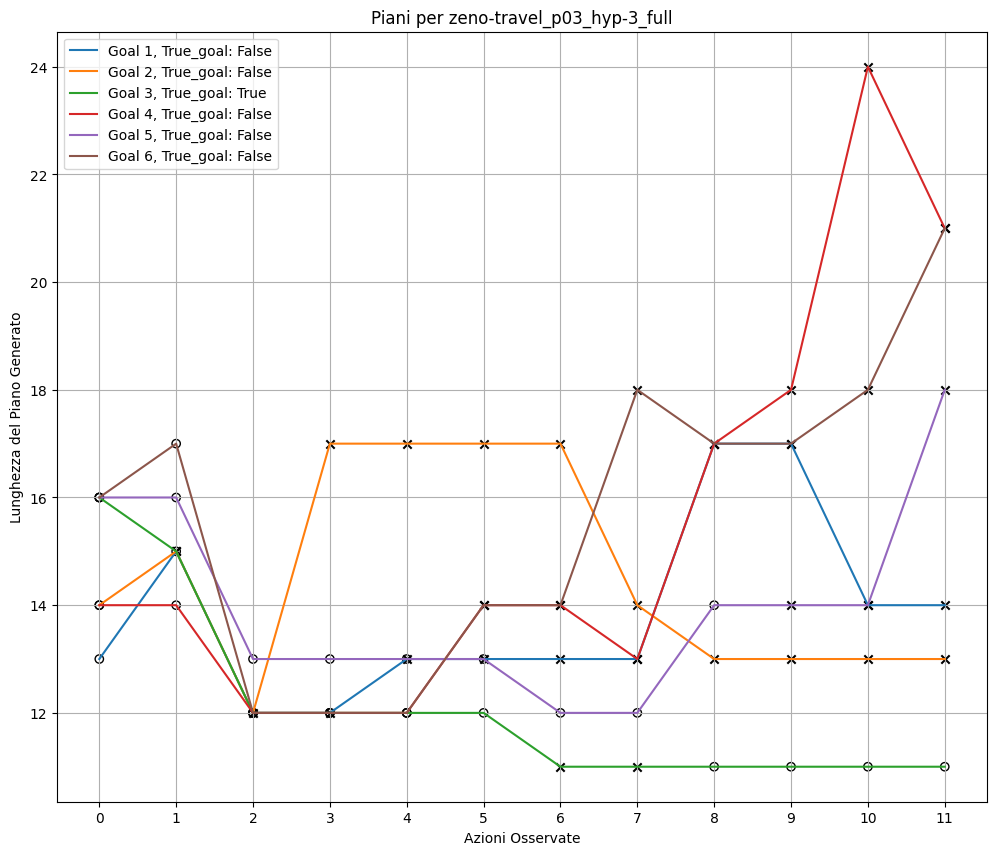

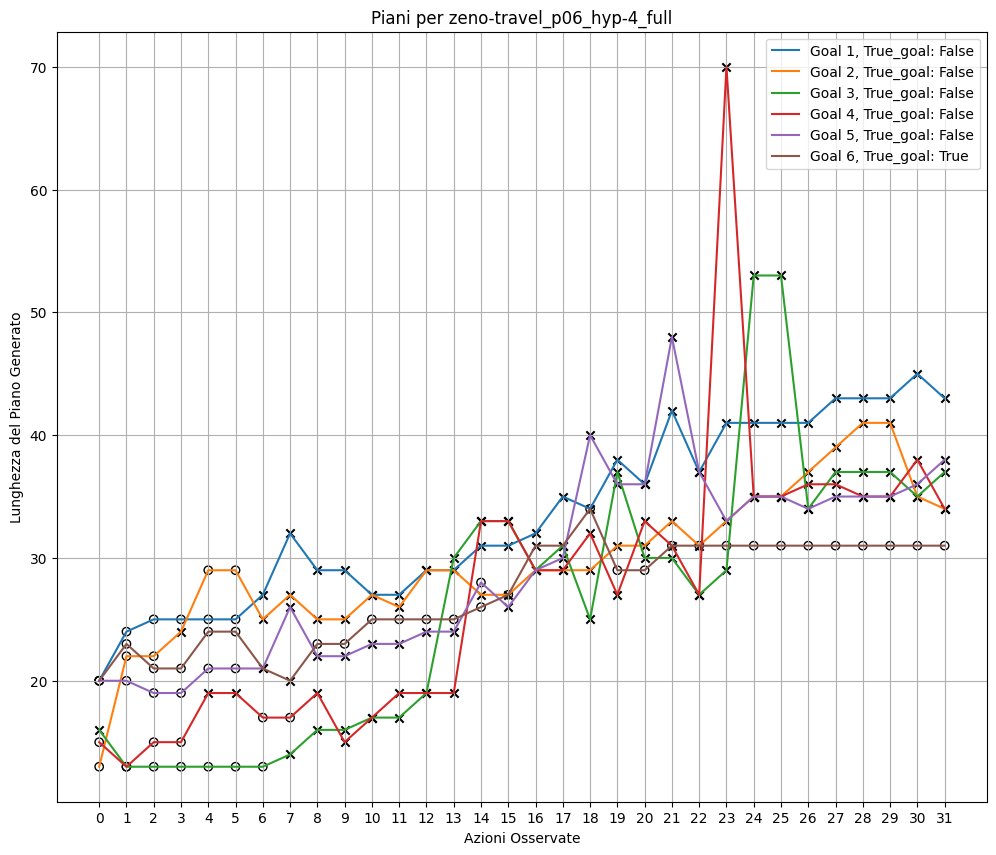

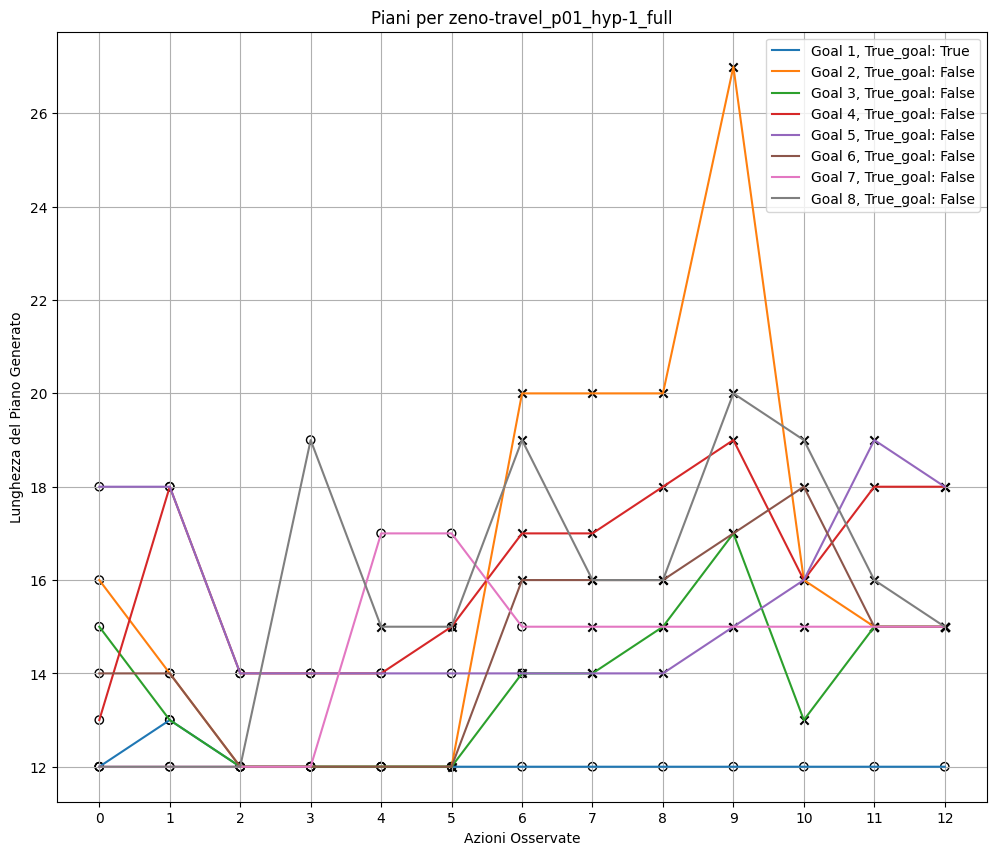

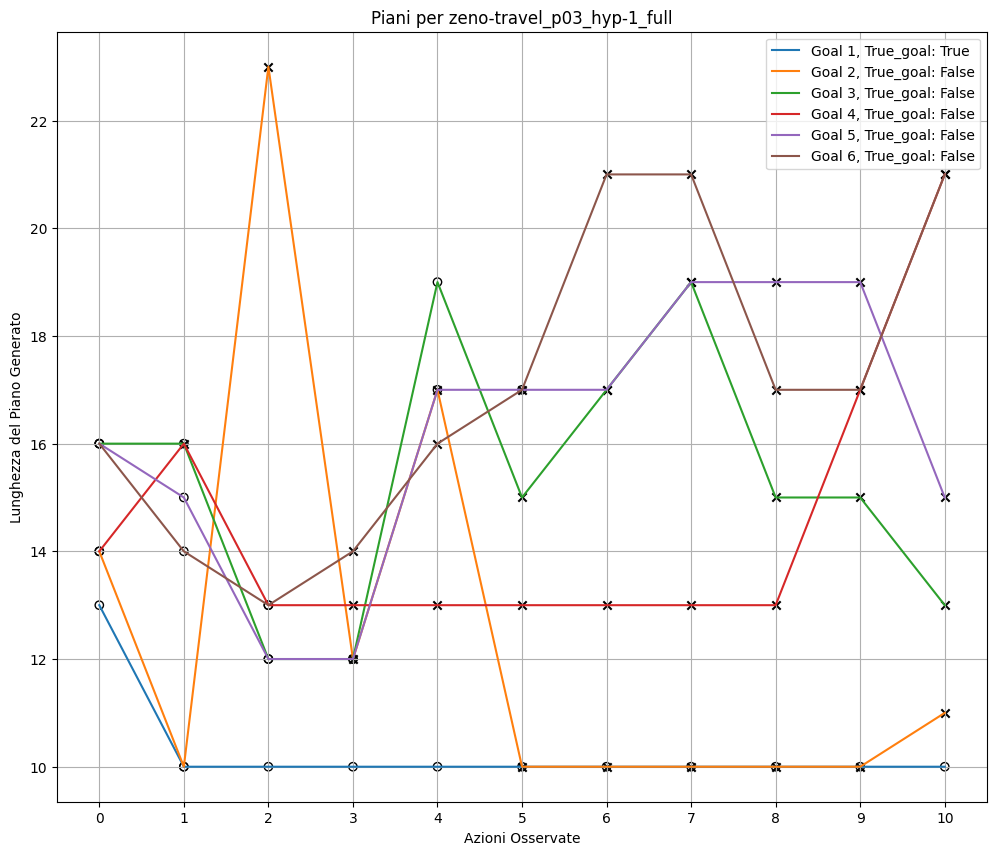

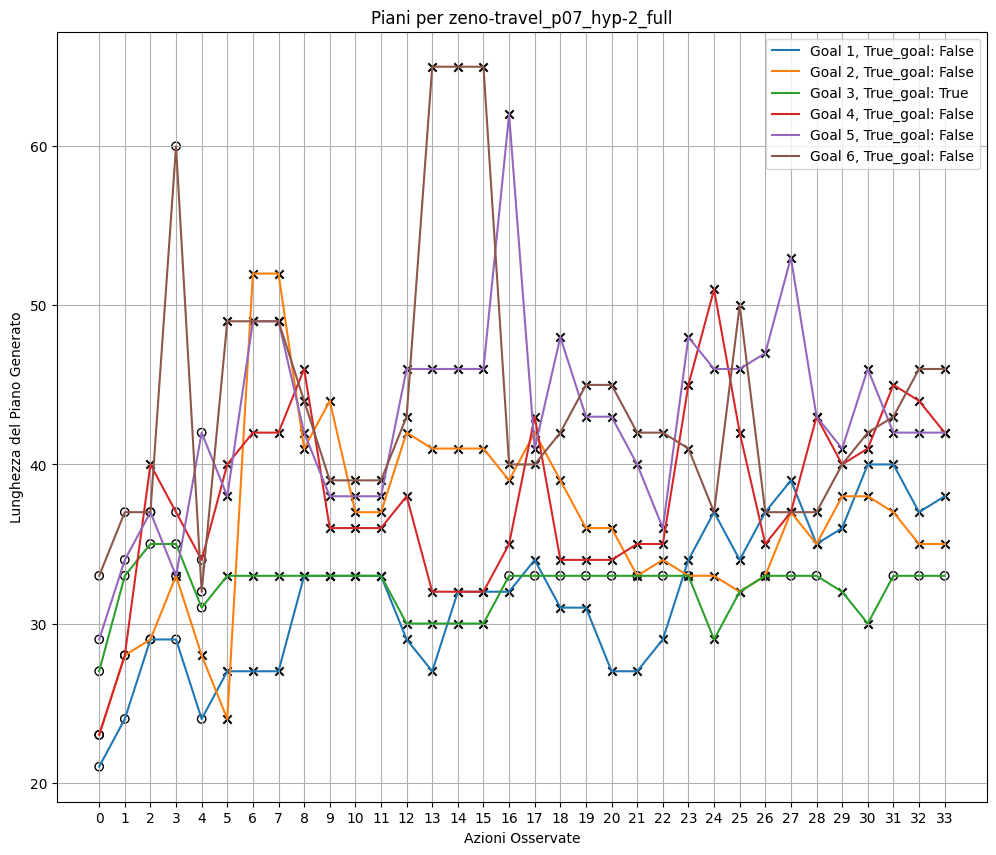

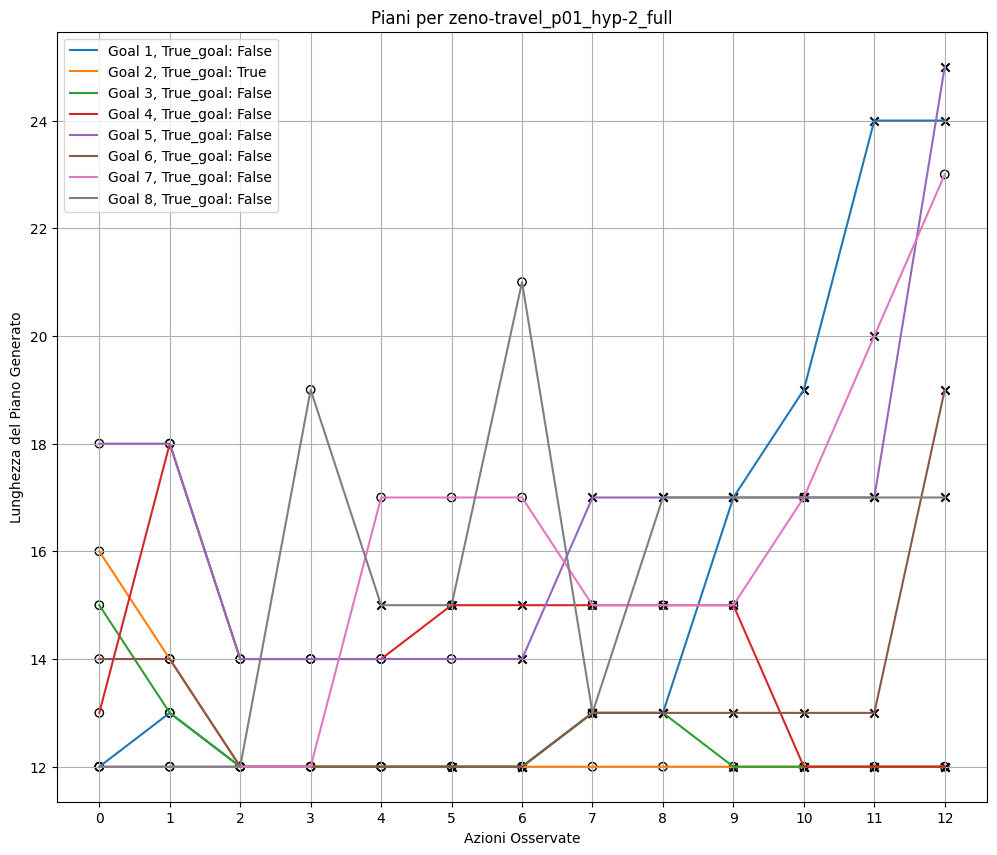

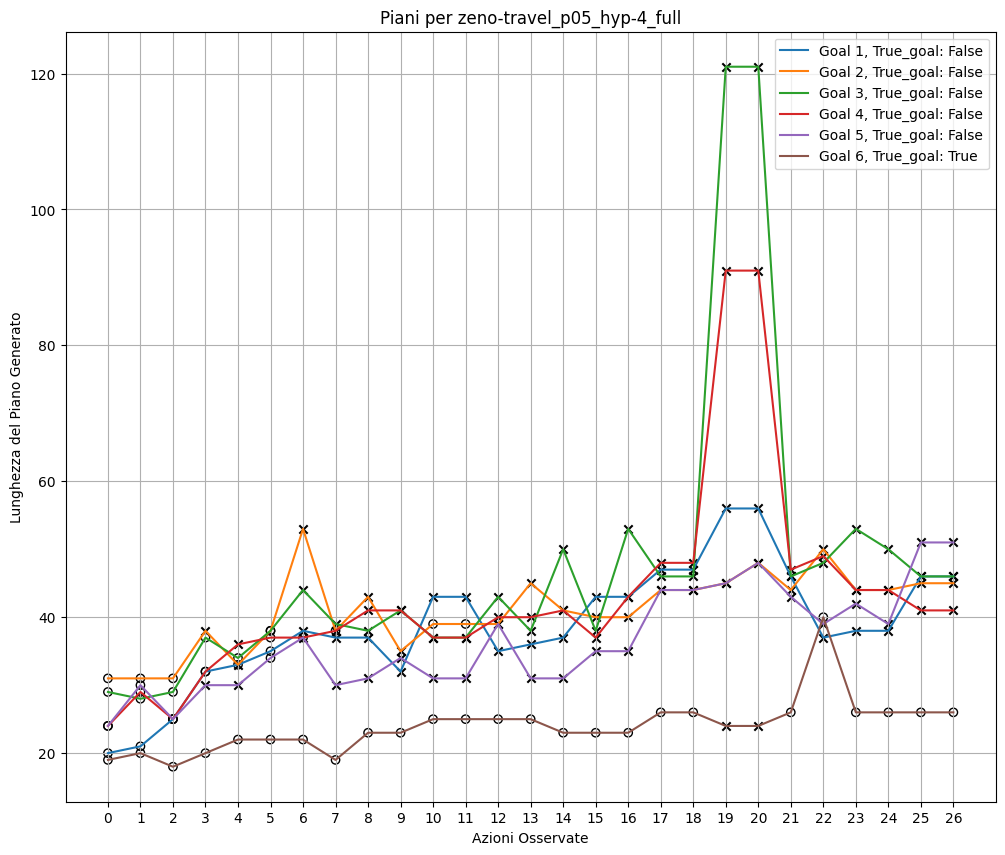

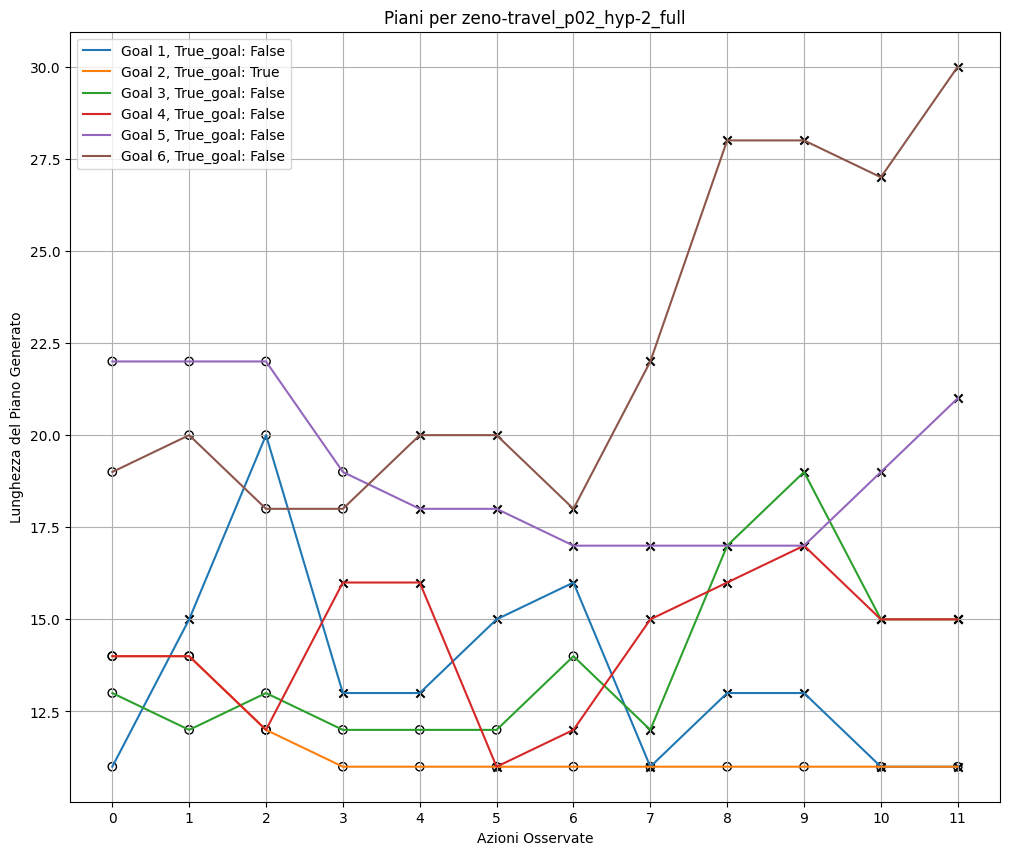

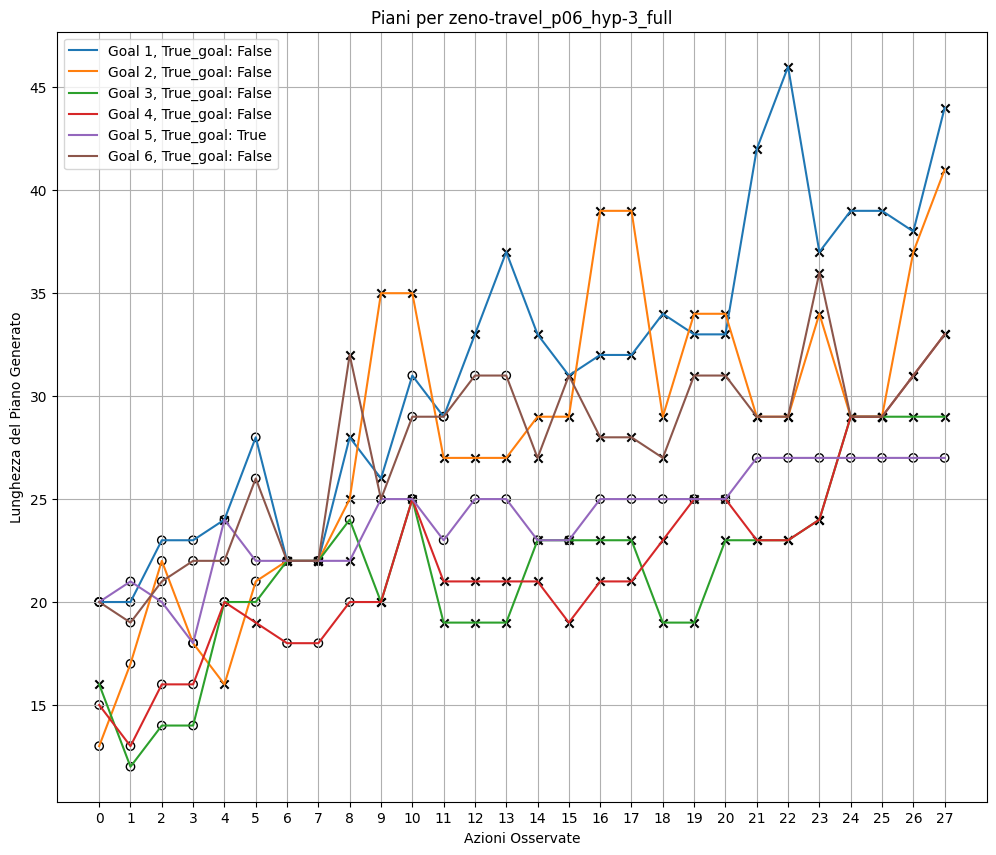

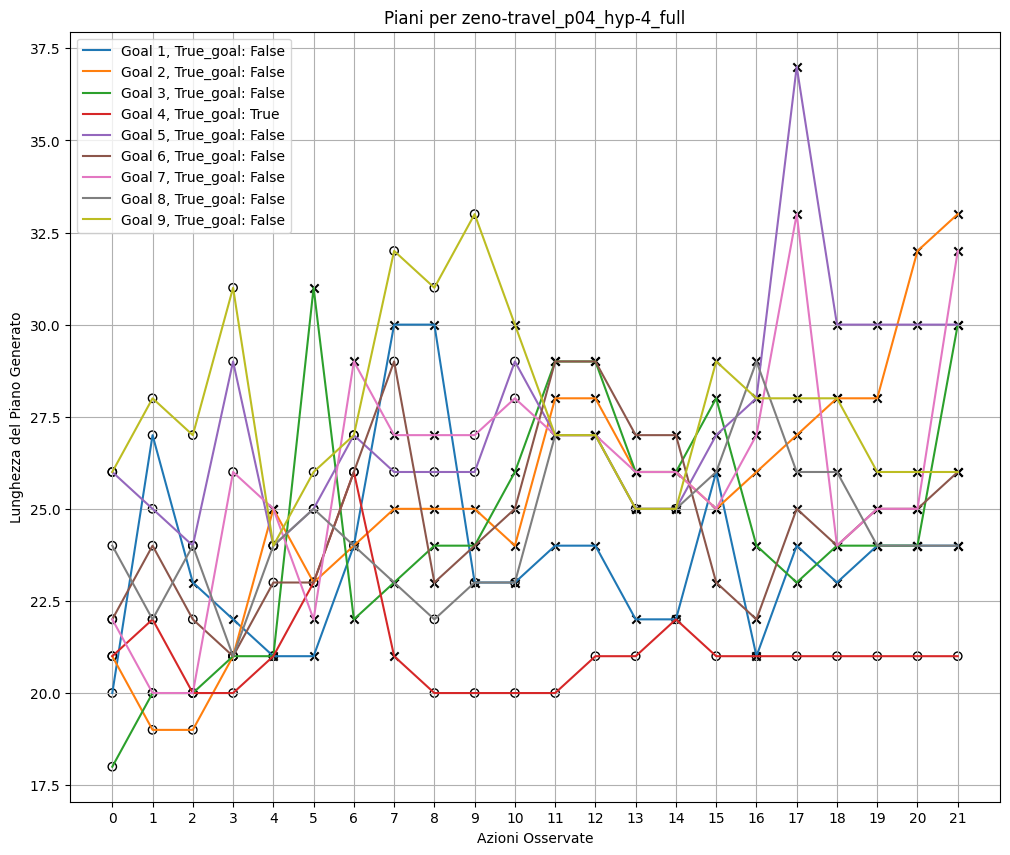

In [ ]:
for problem_data in grafics_data:
    problem_name = problem_data['problem']
    goals = problem_data['goals']
    
    plt.figure(figsize=(12, 10))
    
    for idx, goal in enumerate(goals):  
        # plt.figure(figsize=(10, 6))       
        goal_name = goal['goal']
        actions = goal['actions']
        len_plans = goal['len_plans']
        valid_plans = goal['valid_plans']
        Tgoal = goal["true_goal"]
        
        # Usare marker diversi per piani validi e non validi
        markers = ['o' if valid else 'x' for valid in valid_plans]
        
        # Aggiungere la linea per il piano
        plt.plot(actions, len_plans, label=f'Goal {idx + 1}, True_goal: {Tgoal}')  # Modifica qui
        
        # Aggiungere i punti con marker diversi
        for action, length, marker in zip(actions, len_plans, markers):
            plt.scatter(action, length, marker=marker, color='red' if marker == 'x' else "black", facecolor="none" if marker == 'o' else "black")
         
          
        # plt.title(f'Piani per {problem_name} - Goal {idx + 1}')
        # plt.xlabel('Azioni Osservate')
        # plt.ylabel('Lunghezza del Piano Generato')        
        # plt.xticks(np.arange(min(actions), max(actions) + 1, 1))  # Tick sull'asse X ogni unità
        # plt.legend()
        # plt.grid()
        # plt.show()      
            

    plt.xticks(np.arange(min(actions), max(actions) + 1, 1))  # Tick sull'asse X ogni unità  
    plt.title(f'Piani per {problem_name}')
    plt.xlabel('Azioni Osservate')
    plt.ylabel('Lunghezza del Piano Generato')
    plt.legend()
    plt.grid()
    plt.show()

Per ciascun problema, il numero di volte in cui la prima azione generata da PlanGPT corrisponde all’osservazione successiva, sia in valore assoluto che in percentuale rispetto alla lunghezza del piano originale

In [ ]:
import copy

file_path = '/root/mzizioli/planGPT-OGR/zenotravel-generations-tesi/greedy/generation_output_allActions.json'
with open(file_path, 'r') as file:
    data = json.load(file)

problem = ""
goal = ""
actions = []
len_plans = []
valid_plans = []
len_actions = 0
data_cont = []
cont=0
tot_cont=0
g={}
dati = []

for output in data:   
     
    new_problem = output.get("name")    
    if problem == "":
        problem = new_problem
    
    generated_plan = output["plans"][0]["plan"]
    passed_actions = output.get("action")  
    actions = output.get("actions")
    
    generated_plan = unite_actions(generated_plan, list(dict_actions_domain[domain].keys()), domain)
    actions = unite_actions(actions, list(dict_actions_domain[domain].keys()), domain)        
    passed_actions = unite_actions(passed_actions, list(dict_actions_domain[domain].keys()), domain)  
    len_passed_actions = len(passed_actions)
    
    #print(output["plans"][0]["result"][0], len_passed_actions)
    
    if len_actions == 0:
        len_actions = len(actions)   
        for i in range(len_actions+1):
            g[i]= 0    
    
    if new_problem != problem: 
        data_cont.append({"problem": problem, "cont": cont, "len_actions": len_actions})
        dati.append(g)
        len_actions = len(actions)
        g = {}
        for i in range(len_actions+1):
            g[i]= 0 
        tot_cont+=cont
        cont=0
        problem = new_problem
    # print("passed_actions", passed_actions)    
    # print("actions: ", actions)
    # print("generated_plan: ",generated_plan)
    if len_passed_actions<(len(actions)) and len_passed_actions<len(generated_plan): 
        if generated_plan[len_passed_actions] == actions[len_passed_actions]: 
            #print("==")
            cont+=1 
            g[len_passed_actions] += 1   
      
dati.append(g)      
data_cont.append({"problem": problem, "cont": cont, "len_actions": len_actions})  
tot_cont+=cont           
for i in data_cont:
    print(i)

print(tot_cont)

dati_percentuale=copy.deepcopy(dati)
for j in dati_percentuale:   
    somma = sum(j.values())     
    for k in j: 
        j[k]= j[k]/somma*100     
    


    
        

{'problem': 'zeno-travel_p03_hyp-3_full', 'cont': 23, 'len_actions': 11}
{'problem': 'zeno-travel_p06_hyp-4_full', 'cont': 38, 'len_actions': 31}
{'problem': 'zeno-travel_p01_hyp-1_full', 'cont': 30, 'len_actions': 12}
{'problem': 'zeno-travel_p03_hyp-1_full', 'cont': 21, 'len_actions': 10}
{'problem': 'zeno-travel_p07_hyp-2_full', 'cont': 56, 'len_actions': 33}
{'problem': 'zeno-travel_p01_hyp-2_full', 'cont': 44, 'len_actions': 12}
{'problem': 'zeno-travel_p05_hyp-4_full', 'cont': 37, 'len_actions': 26}
{'problem': 'zeno-travel_p02_hyp-2_full', 'cont': 20, 'len_actions': 11}
{'problem': 'zeno-travel_p06_hyp-3_full', 'cont': 42, 'len_actions': 27}
{'problem': 'zeno-travel_p04_hyp-4_full', 'cont': 43, 'len_actions': 21}
354


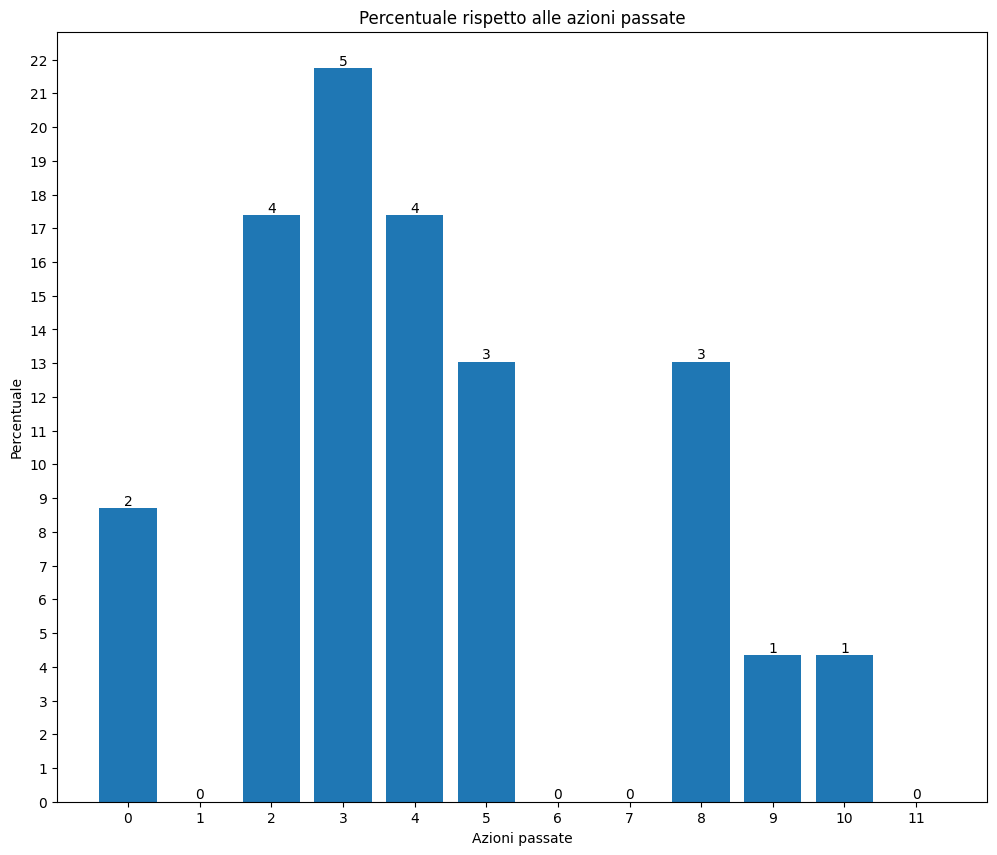

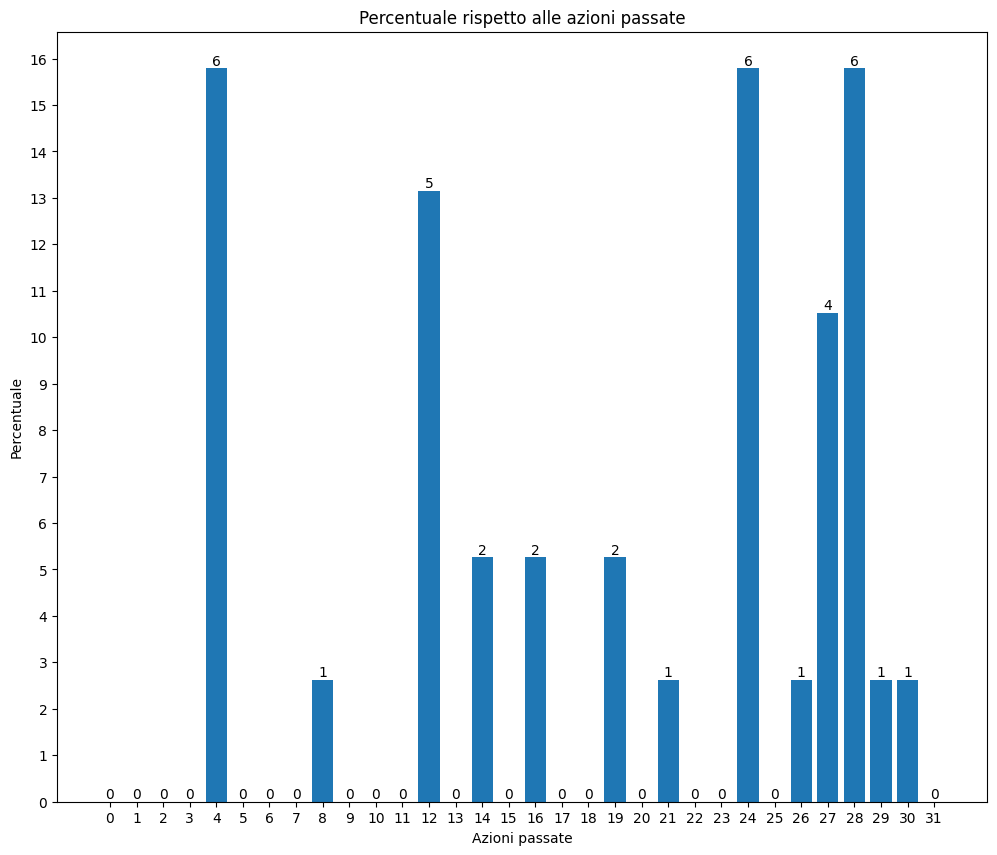

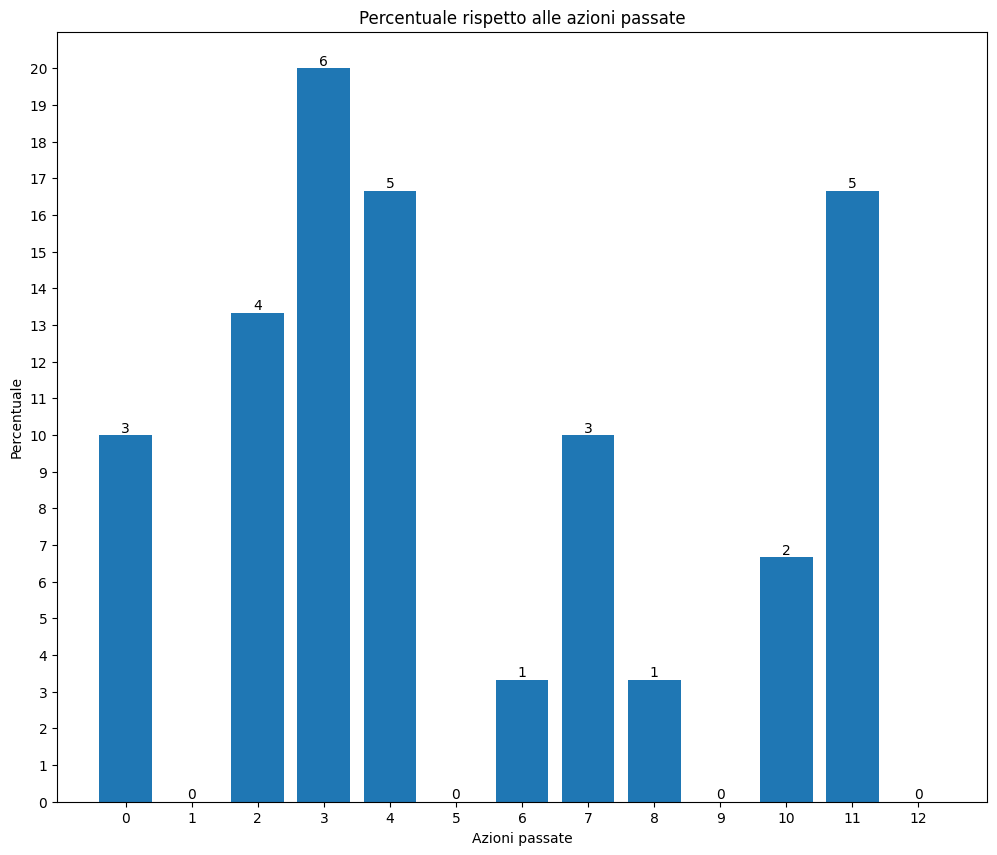

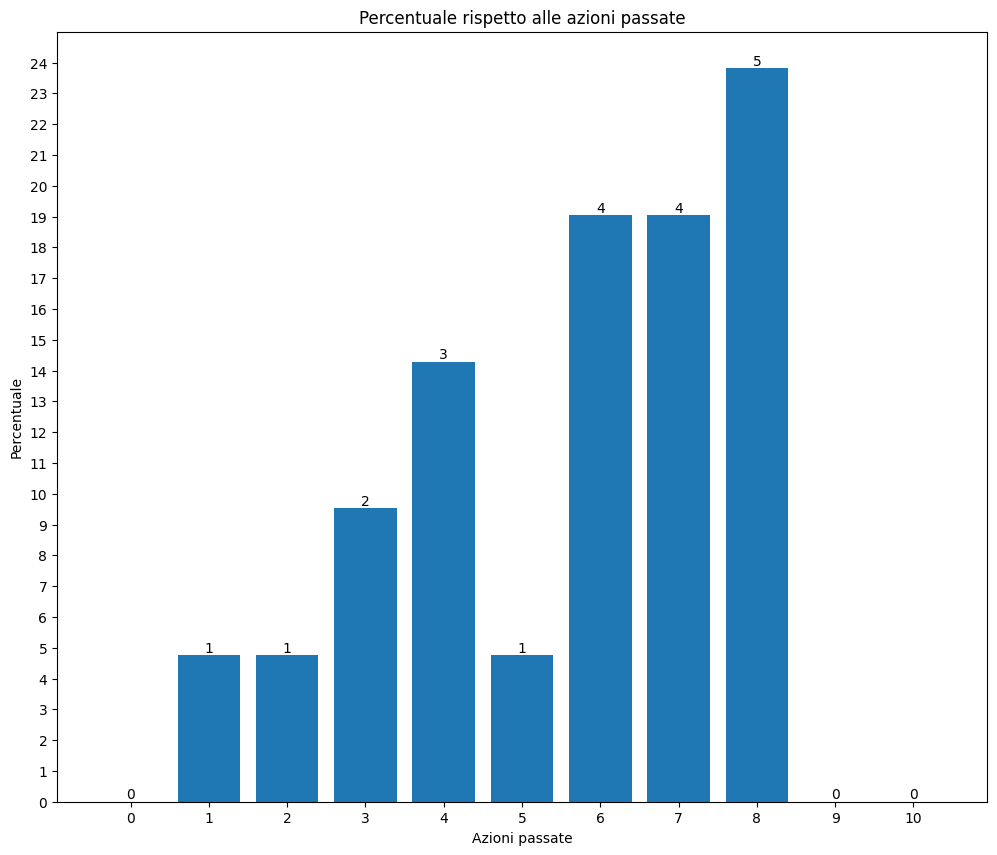

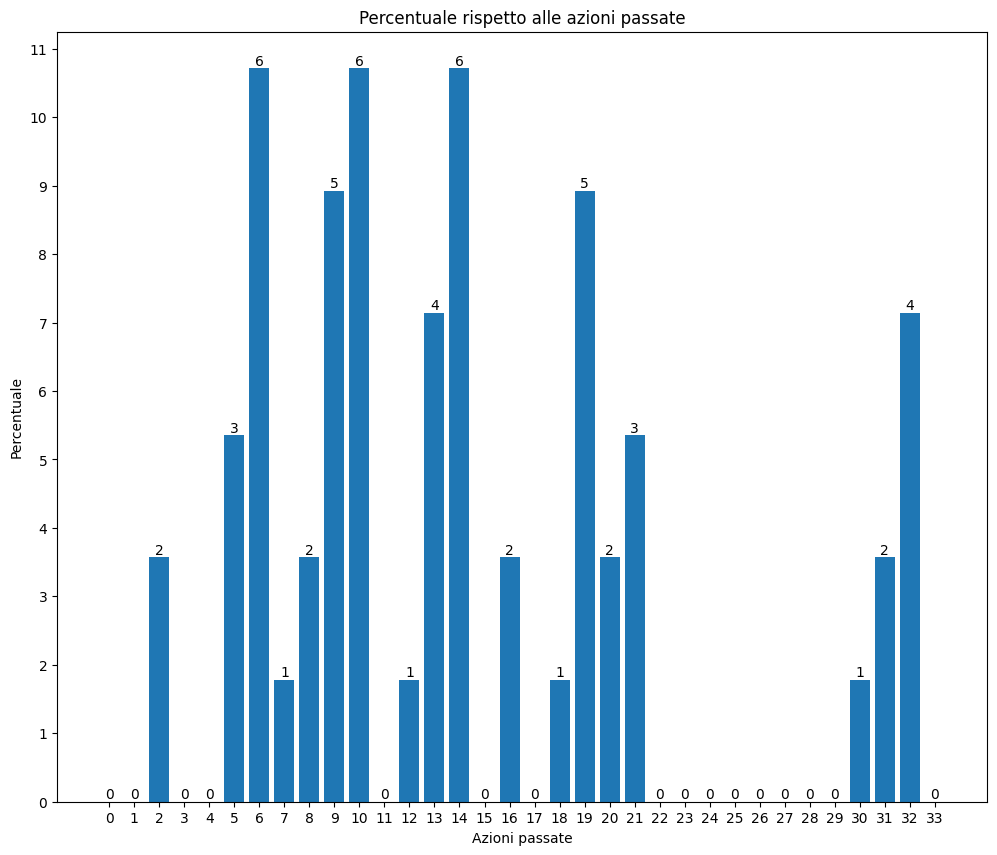

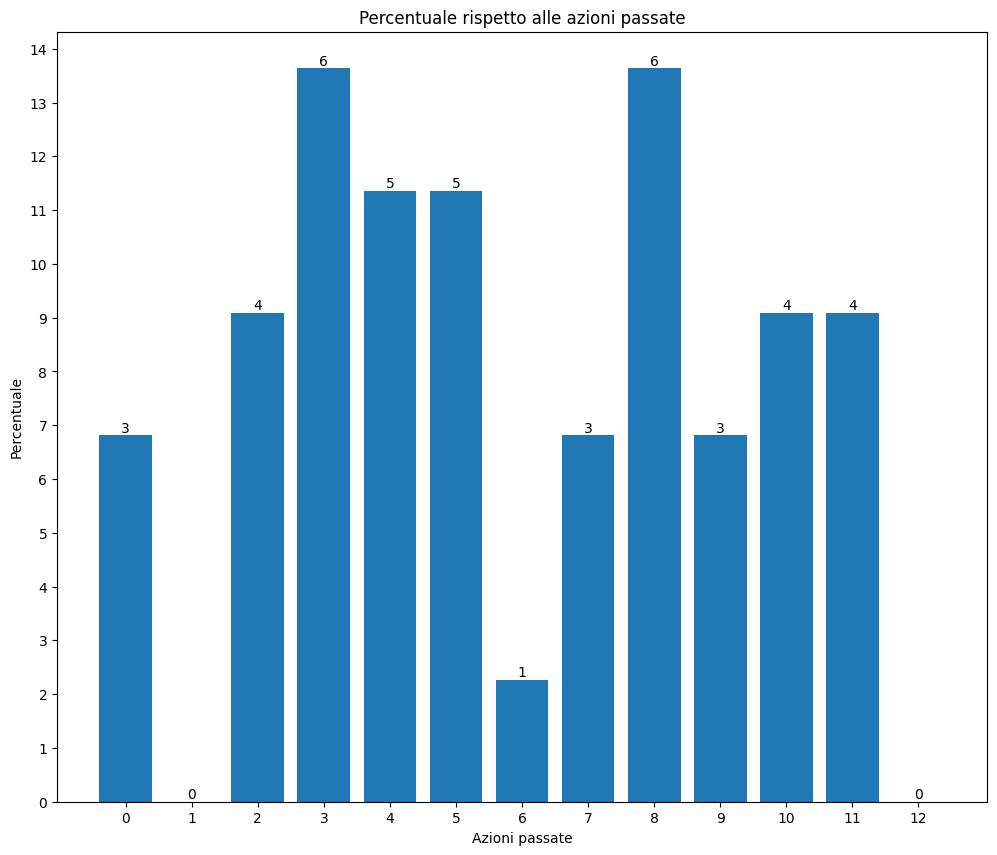

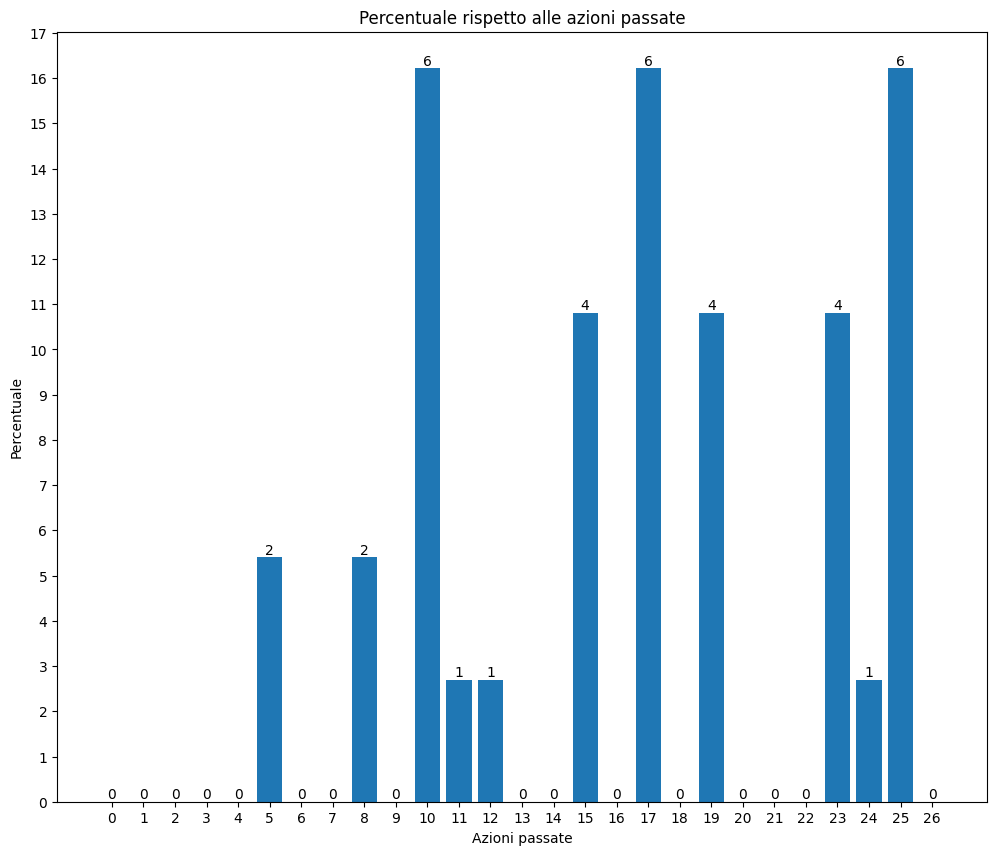

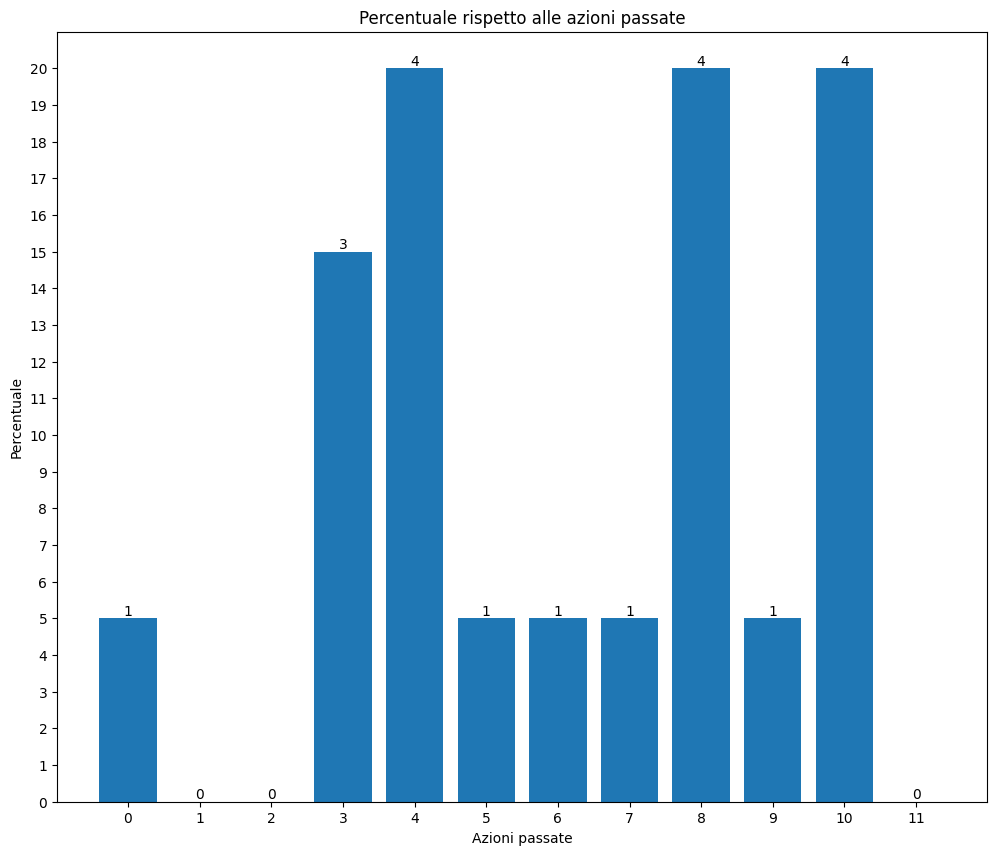

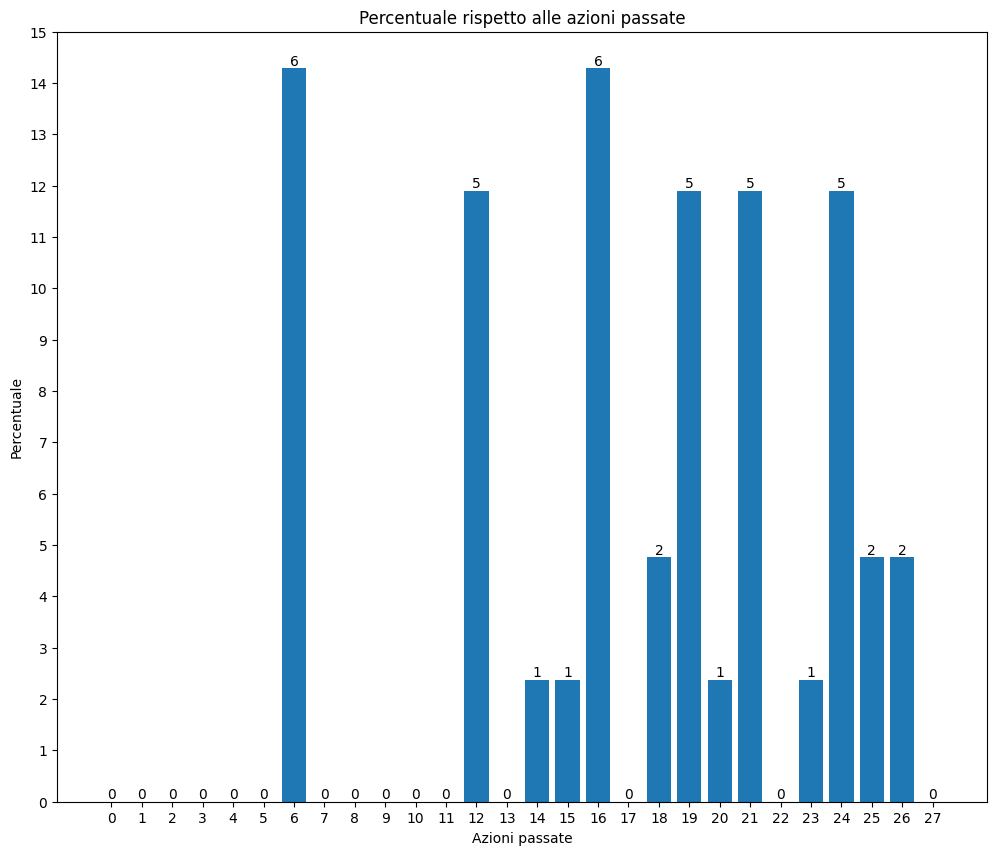

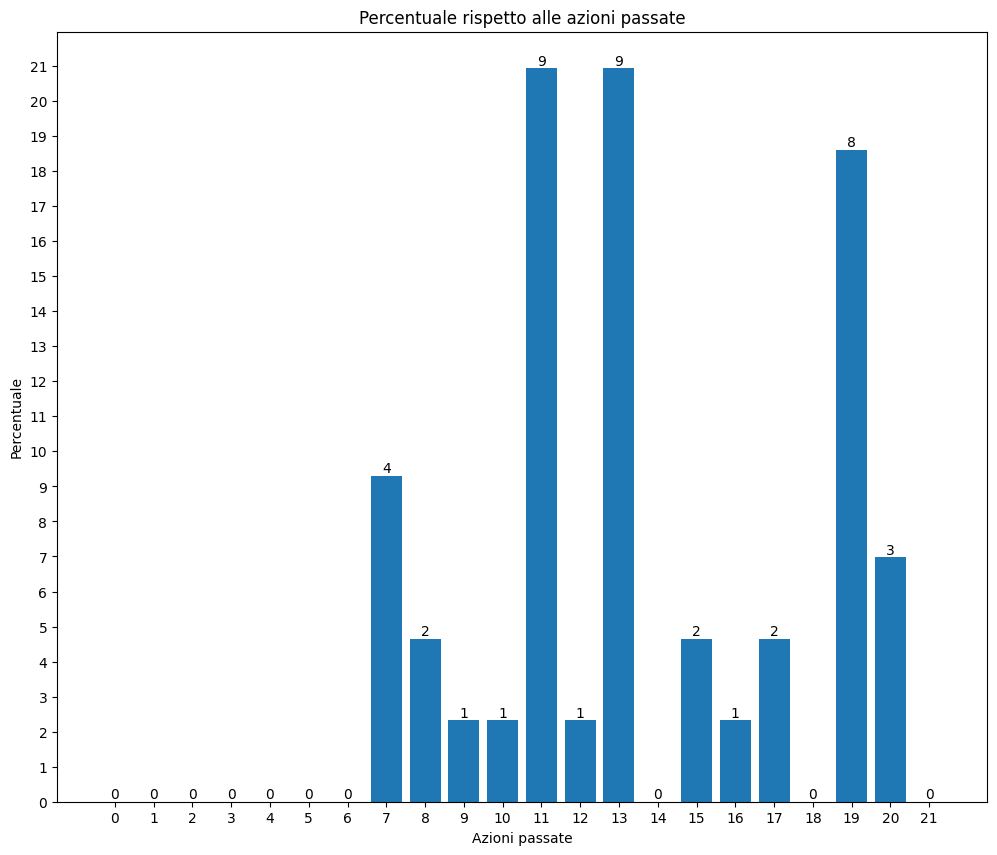

In [ ]:
for data_percentuale,problem,data in zip(dati_percentuale, data_cont, dati):
    problem_name = problem['problem']  
    plt.figure(figsize=(12, 10))
    bars=plt.bar(data_percentuale.keys(), data_percentuale.values())
    for bar,d in zip(bars,data.values()):
        yval = d
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(yval), 
             ha='center', va='bottom', fontsize=10)  # Aggiungi il valore)
        
    plt.title("Percentuale rispetto alle azioni passate")
    plt.ylabel('Percentuale')
    plt.xlabel('Azioni passate')
    plt.xticks(np.arange(min(data_percentuale.keys()), max(data_percentuale.keys()) + 1, 1))  # Tick sull'asse X ogni unità 
    plt.yticks(np.arange(0, max(data_percentuale.values()) + 1, 1))  # Tick sull'asse X ogni unità 